# Import Library

In [1]:
# Import seluruh library yang dipakai
import pandas as pd
import numpy as np
import os, shutil
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Dropout

# Data Loading

In [2]:
# Mengupload file kaggle.json untuk mengambil dataset
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"faizaadinda","key":"879a2477e6cd11e4fdda38385523f100"}'}

In [3]:
# Mengambil dataset
os.makedirs('/root/.kaggle', exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d schemersays/food-recommendation-system
!unzip food-recommendation-system.zip

Dataset URL: https://www.kaggle.com/datasets/schemersays/food-recommendation-system
License(s): unknown
  0% 0.00/24.8k [00:00<?, ?B/s]
100% 24.8k/24.8k [00:00<00:00, 113MB/s]
Archive:  food-recommendation-system.zip
  inflating: 1662574418893344.csv    
  inflating: ratings.csv             


In [4]:
# Membaca dataset yang telah diunggah ke dalam dataframe
food = pd.read_csv('/content/1662574418893344.csv')
rating = pd.read_csv('/content/ratings.csv')

In [5]:
# Melihat data food
food

,Food_ID,Name,C_Type,Veg_Non,Describe
0,1,summer squash salad,Healthy Food,veg,"white balsamic vinegar, lemon juice, lemon rin..."
1,2,chicken minced salad,Healthy Food,non-veg,"olive oil, chicken mince, garlic (minced), oni..."
2,3,sweet chilli almonds,Snack,veg,"almonds whole, egg white, curry leaves, salt, ..."
3,4,tricolour salad,Healthy Food,veg,"vinegar, honey/sugar, soy sauce, salt, garlic ..."
4,5,christmas cake,Dessert,veg,"christmas dry fruits (pre-soaked), orange zest..."
...,...,...,...,...,...
395,396,Kimchi Toast,Korean,veg,"cream cheese, chopped kimchi, scallions,count..."
396,397,"Tacos de Gobernador (Shrimp, Poblano, and Chee...",Mexican,non-veg,"poblano chiles, bacon, shrips, red salsa, garl..."
397,398,Melted Broccoli Pasta With Capers and Anchovies,French,non-veg,"broccoli,Bread Crumbs, anchovy fillets, garli..."
398,399,Lemon-Ginger Cake with Pistachios,Dessert,non-veg,"egg yolks,lemon juice, unsalted butter, all pu..."


In [6]:
# Melihat data rating
rating

,User_ID,Food_ID,Rating
0,1.0,88.0,4.0
1,1.0,46.0,3.0
2,1.0,24.0,5.0
3,1.0,25.0,4.0
4,2.0,49.0,1.0
...,...,...,...
507,99.0,22.0,1.0
508,100.0,24.0,10.0
509,100.0,233.0,10.0
510,100.0,29.0,7.0


# Data Understanding

In [7]:
# Melihat info umum dataset (fitur, type data, jumlah entry, dan nilai null)
print("Food Info:")
print(food.info())
print("\nRatings Info:")
print(rating.info())

Food Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Food_ID   400 non-null    int64 
 1   Name      400 non-null    object
 2   C_Type    400 non-null    object
 3   Veg_Non   400 non-null    object
 4   Describe  400 non-null    object
dtypes: int64(1), object(4)
memory usage: 15.8+ KB
None

Ratings Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   User_ID  511 non-null    float64
 1   Food_ID  511 non-null    float64
 2   Rating   511 non-null    float64
dtypes: float64(3)
memory usage: 12.1 KB
None


In [8]:
# Melihat apakah ada missing value
print("Missing values in movies:\n", food.isnull().sum())
print("Missing values in ratings:\n", rating.isnull().sum())

# Melihat apakah ada nilai duplikat
print("Duplicated rows in movies:", food.duplicated().sum())
print("Duplicated rows in ratings:", rating.duplicated().sum())

Missing values in movies:
 Food_ID     0
Name        0
C_Type      0
Veg_Non     0
Describe    0
dtype: int64
Missing values in ratings:
 User_ID    1
Food_ID    1
Rating     1
dtype: int64
Duplicated rows in movies: 0
Duplicated rows in ratings: 0


In [9]:
# Melihat nilai unik makanan dan course makanan
print("Jumlah unique nama makanan:", food['Name'].nunique())
print("Jumlah unique Course:", food['C_Type'].nunique())

Jumlah unique nama makanan: 400
Jumlah unique Course: 16


In [10]:
# Melihat statistik deskriptif data rating
rating.describe()

,User_ID,Food_ID,Rating
count,511.000000,511.000000,511.000000
mean,49.068493,125.311155,5.438356
std,28.739213,91.292629,2.866236
min,1.000000,1.000000,1.000000
25%,25.000000,45.500000,3.000000
50%,49.000000,111.000000,5.000000
75%,72.000000,204.000000,8.000000
max,100.000000,309.000000,10.000000


<ipython-input-11-c45a9d267990>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='C_Type', data=food, palette='viridis')


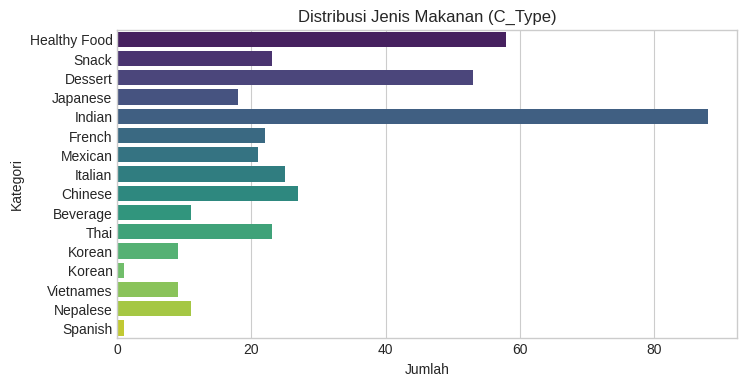

In [11]:
# Ukuran plot default
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (8, 4)

# Visualisasi distribusi kolom C_Type: Jenis makanan
sns.countplot(y='C_Type', data=food, palette='viridis')
plt.title('Distribusi Jenis Makanan (C_Type)')
plt.xlabel('Jumlah')
plt.ylabel('Kategori')
plt.show()

<ipython-input-12-35ebc3817e12>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Veg_Non', data=food, palette='viridis')


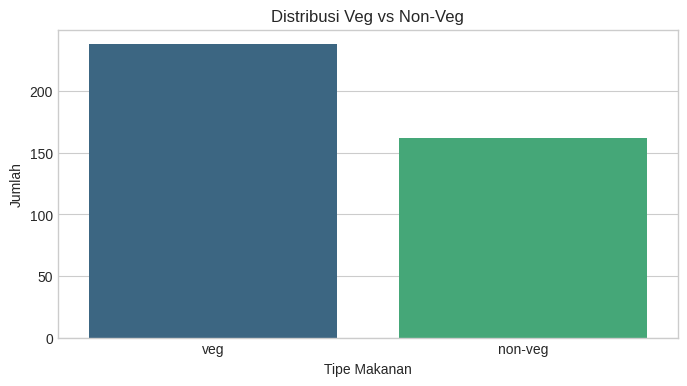

In [12]:
# Visualisasi distribusi kolom Veg_Non: Vegetarian vs Non-Vegetarian
sns.countplot(x='Veg_Non', data=food, palette='viridis')
plt.title('Distribusi Veg vs Non-Veg')
plt.xlabel('Tipe Makanan')
plt.ylabel('Jumlah')
plt.show()

<ipython-input-13-3903e63624a7>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating', data=rating, palette='viridis')


Text(0, 0.5, 'Jumlah')

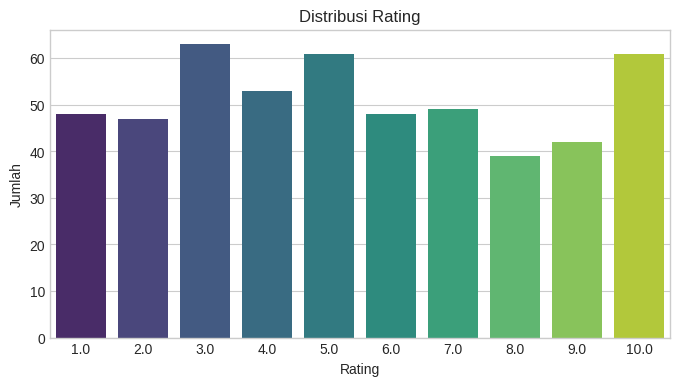

In [13]:
# Visualisasi distribusi kolom Rating
sns.countplot(x='Rating', data=rating, palette='viridis')
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah')

# Data Preparation

In [14]:
# Menghapus missing value pada data rating
rating.dropna(axis=0 ,inplace=True)

# Cek kembali missing value
print("Missing values in ratings:\n", rating.isnull().sum())

Missing values in ratings:
 User_ID    0
Food_ID    0
Rating     0
dtype: int64


In [15]:
# Mengubah type data User_ID, Food_ID, dan Rating
rating['User_ID'] = rating['User_ID'].astype(int)
rating['Food_ID'] = rating['Food_ID'].astype(int)
rating['Rating'] = rating['Rating'].astype(float)

In [16]:
# Membersihkan teks dari karakter non-alfanumerik dan mengubahnya ke huruf kecil
# Tujuan: Standarisasi format teks untuk mencegah inkonsistensi data (misal: 'Indian' dan 'indian' dianggap berbeda)
def clean_text(text):
    if isinstance(text, str):
        return re.sub(r'[^a-zA-Z0-9 ]', '', text.lower())
    return ''

# Menerapkan fungsi pembersihan teks ke kolom-kolom teks pada dataset
food['Name'] = food['Name'].apply(clean_text)
food['C_Type'] = food['C_Type'].apply(clean_text)
food['Veg_Non'] = food['Veg_Non'].apply(clean_text)
food['Describe'] = food['Describe'].apply(clean_text)

# Modelling Content Based Filtering

In [17]:
# Menggabungkan kolom teks menjadi satu kolom 'combined' untuk TF-IDF
food['combined'] = food['Name'] + ' ' + food['C_Type'] + ' '  + ' ' + food['Describe']

In [18]:
# Menerapkan TfidfVectorizer untuk menghasilkan representasi vektor dari teks.
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(food['combined'])

In [19]:
# Menghitung tingkat kemiripan antar makanan berdasarkan teks tersebut
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [20]:
# Membuat fungsi untuk merekomendasikan sistem
def recommend_food(input_name, cosine_sim=cosine_sim):
    # Reset index untuk memastikan urutan index sesuai cosine_sim
    food_reset = food.reset_index()

    # Cari makanan yang mengandung input keyword (case-insensitive)
    matches = food_reset[food_reset['Name'].str.lower().str.contains(input_name.lower())]
    if matches.empty:
        return f"Makanan yang mengandung '{input_name}' tidak ditemukan dalam data."
    idx = matches.index[0]

    # Hitung similarity
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]  # top 5 recommendation

    food_indices = [i[0] for i in sim_scores]

    return food_reset[['Name', 'C_Type', 'Describe']].iloc[food_indices]

In [53]:
# Tes model
recommend_food('pasta')

,Name,C_Type,Describe
397,melted broccoli pasta with capers and anchovies,french,broccolibread crumbs anchovy fillets garlic c...
385,pasta with garlicscape pesto,italian,pistachios parmigianoreggiano cheesesalt and b...
153,fish with white sauce,italian,fillet fish oil milk flour butter salt ground ...
124,cheese chicken kebabs,indian,chicken thais garlic paste garlic paste yellow...
340,cheese naan,indian,aall purpose flour yougurt cheese


# Modelling Collaborative Filtering

In [22]:
# Encoding ID Pengguna dan Makanan
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

rating['user'] = user_encoder.fit_transform(rating['User_ID'])
rating['item'] = item_encoder.fit_transform(rating['Food_ID'])

In [23]:
# Deklarasian variabel fitur (x) dan target (y) untuk proses pelatihan model
x = rating[['user', 'item']].values
y = rating['Rating'].values

# Split dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [24]:
# Membangun model
num_users = len(user_encoder.classes_)
num_items = len(item_encoder.classes_)
embedding_size = 50

user_input = Input(shape=(1,))
user_embedding = Embedding(num_users, embedding_size)(user_input)
user_vec = Flatten()(user_embedding)

item_input = Input(shape=(1,))
item_embedding = Embedding(num_items, embedding_size)(item_input)
item_vec = Flatten()(item_embedding)

# Concatenate + Dense layers
concatenated = Concatenate()([user_vec, item_vec])
x = Dense(128, activation='relu')(concatenated)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1)(x)

model = Model([user_input, item_input], output)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


In [25]:
# Train model
history = model.fit([x_train[:,0], x_train[:,1]], y_train,
          validation_data=([x_test[:,0], x_test[:,1]], y_test),
          epochs=20, batch_size=16)

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 34.3057 - mae: 5.0894 - val_loss: 32.7214 - val_mae: 4.9847
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 24.0333 - mae: 4.0462 - val_loss: 11.5143 - val_mae: 2.7164
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.3780 - mae: 2.4137 - val_loss: 9.0340 - val_mae: 2.4811
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.7385 - mae: 1.9742 - val_loss: 9.5017 - val_mae: 2.5395
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5063 - mae: 1.7004 - val_loss: 9.9352 - val_mae: 2.5625
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.1305 - mae: 1.4073 - val_loss: 10.0425 - val_mae: 2.5826
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0001 - mae: 1.3059 - val_loss: 10.5023 - val_mae: 2.6005
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7501 - mae: 1.2474 - val_loss: 10.9338 - val_mae: 2.6208
Epoch 9/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1747

In [27]:
# Membuat fungsi rekomendasi makanan kepada pengguna tertentu
def recommend_for_user(user_Id, top_n=10):
    user_idx = user_encoder.transform([user_Id])[0]
    all_items = np.arange(num_items)
    user_array = np.full_like(all_items, user_idx)

    predictions = model.predict([user_array, all_items], verbose=0).flatten()
    top_indices = predictions.argsort()[-top_n:][::-1]

    recommended_item_ids = item_encoder.inverse_transform(top_indices)

    return food[food['Food_ID'].isin(recommended_item_ids)][['Food_ID', 'Name', 'C_Type', 'Veg_Non']]


In [28]:
# Tes model
recommend_for_user('5')

,Food_ID,Name,C_Type,Veg_Non
68,69,banana and maple ice lollies,dessert,veg
93,94,chicken sukka,indian,nonveg
104,105,chicken tenders,snack,nonveg
126,127,cajun spiced turkey wrapped with bacon,mexican,nonveg
138,139,surmai curry with lobster butter rice,thai,veg
171,172,zucchini methi pulao,indian,veg
195,196,bread dahi vada,indian,veg
272,273,corn jalapeno poppers,mexican,veg
275,276,apple and pear cake,healthy food,veg
281,282,fruit cube salad,healthy food,veg


# Evaluasi

### Evaluasi CBF

In [46]:
# Membuat fungsi untuk menghitung presisi model
def precision_at_k(query_food_name, recommendations, food_data):
    matches = food_data[food_data['Name'].str.lower().str.contains(query_food_name.lower())]
    if matches.empty:
        return f"Makanan '{query_food_name}' tidak ditemukan dalam data."

    # Ambil C_Type dari hasil match pertama
    query_type = matches.iloc[0]['C_Type'].lower().strip()

    # Hitung jumlah rekomendasi yang punya C_Type yang sama
    relevant_count = sum(
        rec_type.lower().strip() == query_type
        for rec_type in recommendations['C_Type']
    )

    precision = relevant_count / len(recommendations)
    return precision


In [57]:
# Menghitung presisi
recs = recommend_food('kimchi', cosine_sim)
precision = precision_at_k('kimchi', recs, food)
print(f'Precision: {precision:.2f}')

Precision: 0.80


Dalam pengujian dengan input makanan "kimchi", dari lima hasil rekomendasi teratas yang dihasilkan oleh sistem, sebanyak empat memiliki kategori yang sama. Sehingga, nilai Precision@5 yang dihasilkan adalah 0.80, atau 80%.

### Evaluasi CF

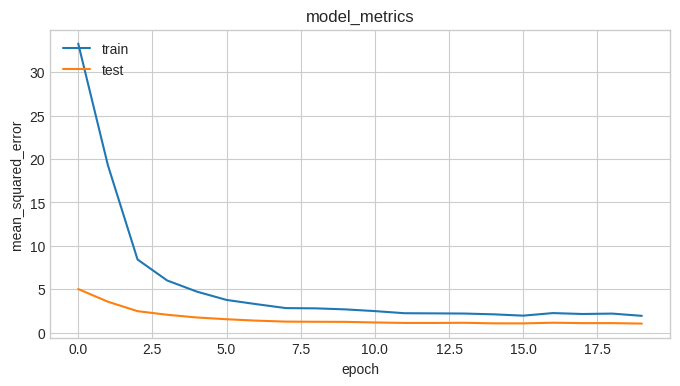

In [59]:
# Membuat visualisasi untuk model metrik
plt.plot(history.history['loss'])
plt.plot(history.history['mae'])
plt.title('model_metrics')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Model berhasil belajar dengan baik dan mencapai konvergensi. Selisih antara train loss dan validation loss juga tidak terlalu jauh, yang menunjukkan bahwa model model tidak mengalami overfitting secara signifikan. Selain itu, nilai MAE validasi yang konsisten di kisaran 2.7 menandakan bahwa prediksi model cukup stabil dan dapat diandalkan untuk merekomendasikan makanan berdasarkan preferensi pengguna.